# Предсказание количества арендованных велосипедов

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


## 1. Загрузка датасета

In [140]:
df = pd.read_csv(
    "SeoulBikeData.csv",
    parse_dates=['Date'],
    dayfirst=True,
    encoding="latin1"
)

display(df.head())

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## 2. Типы данных и наличие пропущенных значений

In [141]:
display(df.info())
display(df.describe())
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       8760 non-null   datetime64[ns]
 1   Rented Bike Count          8760 non-null   int64         
 2   Hour                       8760 non-null   int64         
 3   Temperature(°C)            8760 non-null   float64       
 4   Humidity(%)                8760 non-null   int64         
 5   Wind speed (m/s)           8760 non-null   float64       
 6   Visibility (10m)           8760 non-null   int64         
 7   Dew point temperature(°C)  8760 non-null   float64       
 8   Solar Radiation (MJ/m2)    8760 non-null   float64       
 9   Rainfall(mm)               8760 non-null   float64       
 10  Snowfall (cm)              8760 non-null   float64       
 11  Seasons                    8760 non-null   object        
 12  Holida

None

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,2018-05-31 23:59:59.999999744,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
min,2017-12-01 00:00:00,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,2018-03-02 00:00:00,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,2018-06-01 00:00:00,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,2018-08-31 00:00:00,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,2018-11-30 00:00:00,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000
std,NaN,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746


,0
Date,0
Rented Bike Count,0
Hour,0
Temperature(°C),0
Humidity(%),0
Wind speed (m/s),0
Visibility (10m),0
Dew point temperature(°C),0
Solar Radiation (MJ/m2),0
Rainfall(mm),0


## 3. Разделение данных на обучающую и тестовую выборки в соотношении 70:30 с сохранением временного порядка

In [116]:
train_size = int(0.7 * len(df))
train_df = df[:train_size]
test_df = df[train_size:]

original_train_df = train_df.copy()

print(f"Обучающая выборка: {len(train_df)} записей")
print(f"Тестовая выборка: {len(test_df)} записей")

Обучающая выборка: 6132 записей
Тестовая выборка: 2628 записей


## 4. Анализ выбросов в числовых признаках на обучающей выборке с использованием метода межквартильного размаха (IQR)

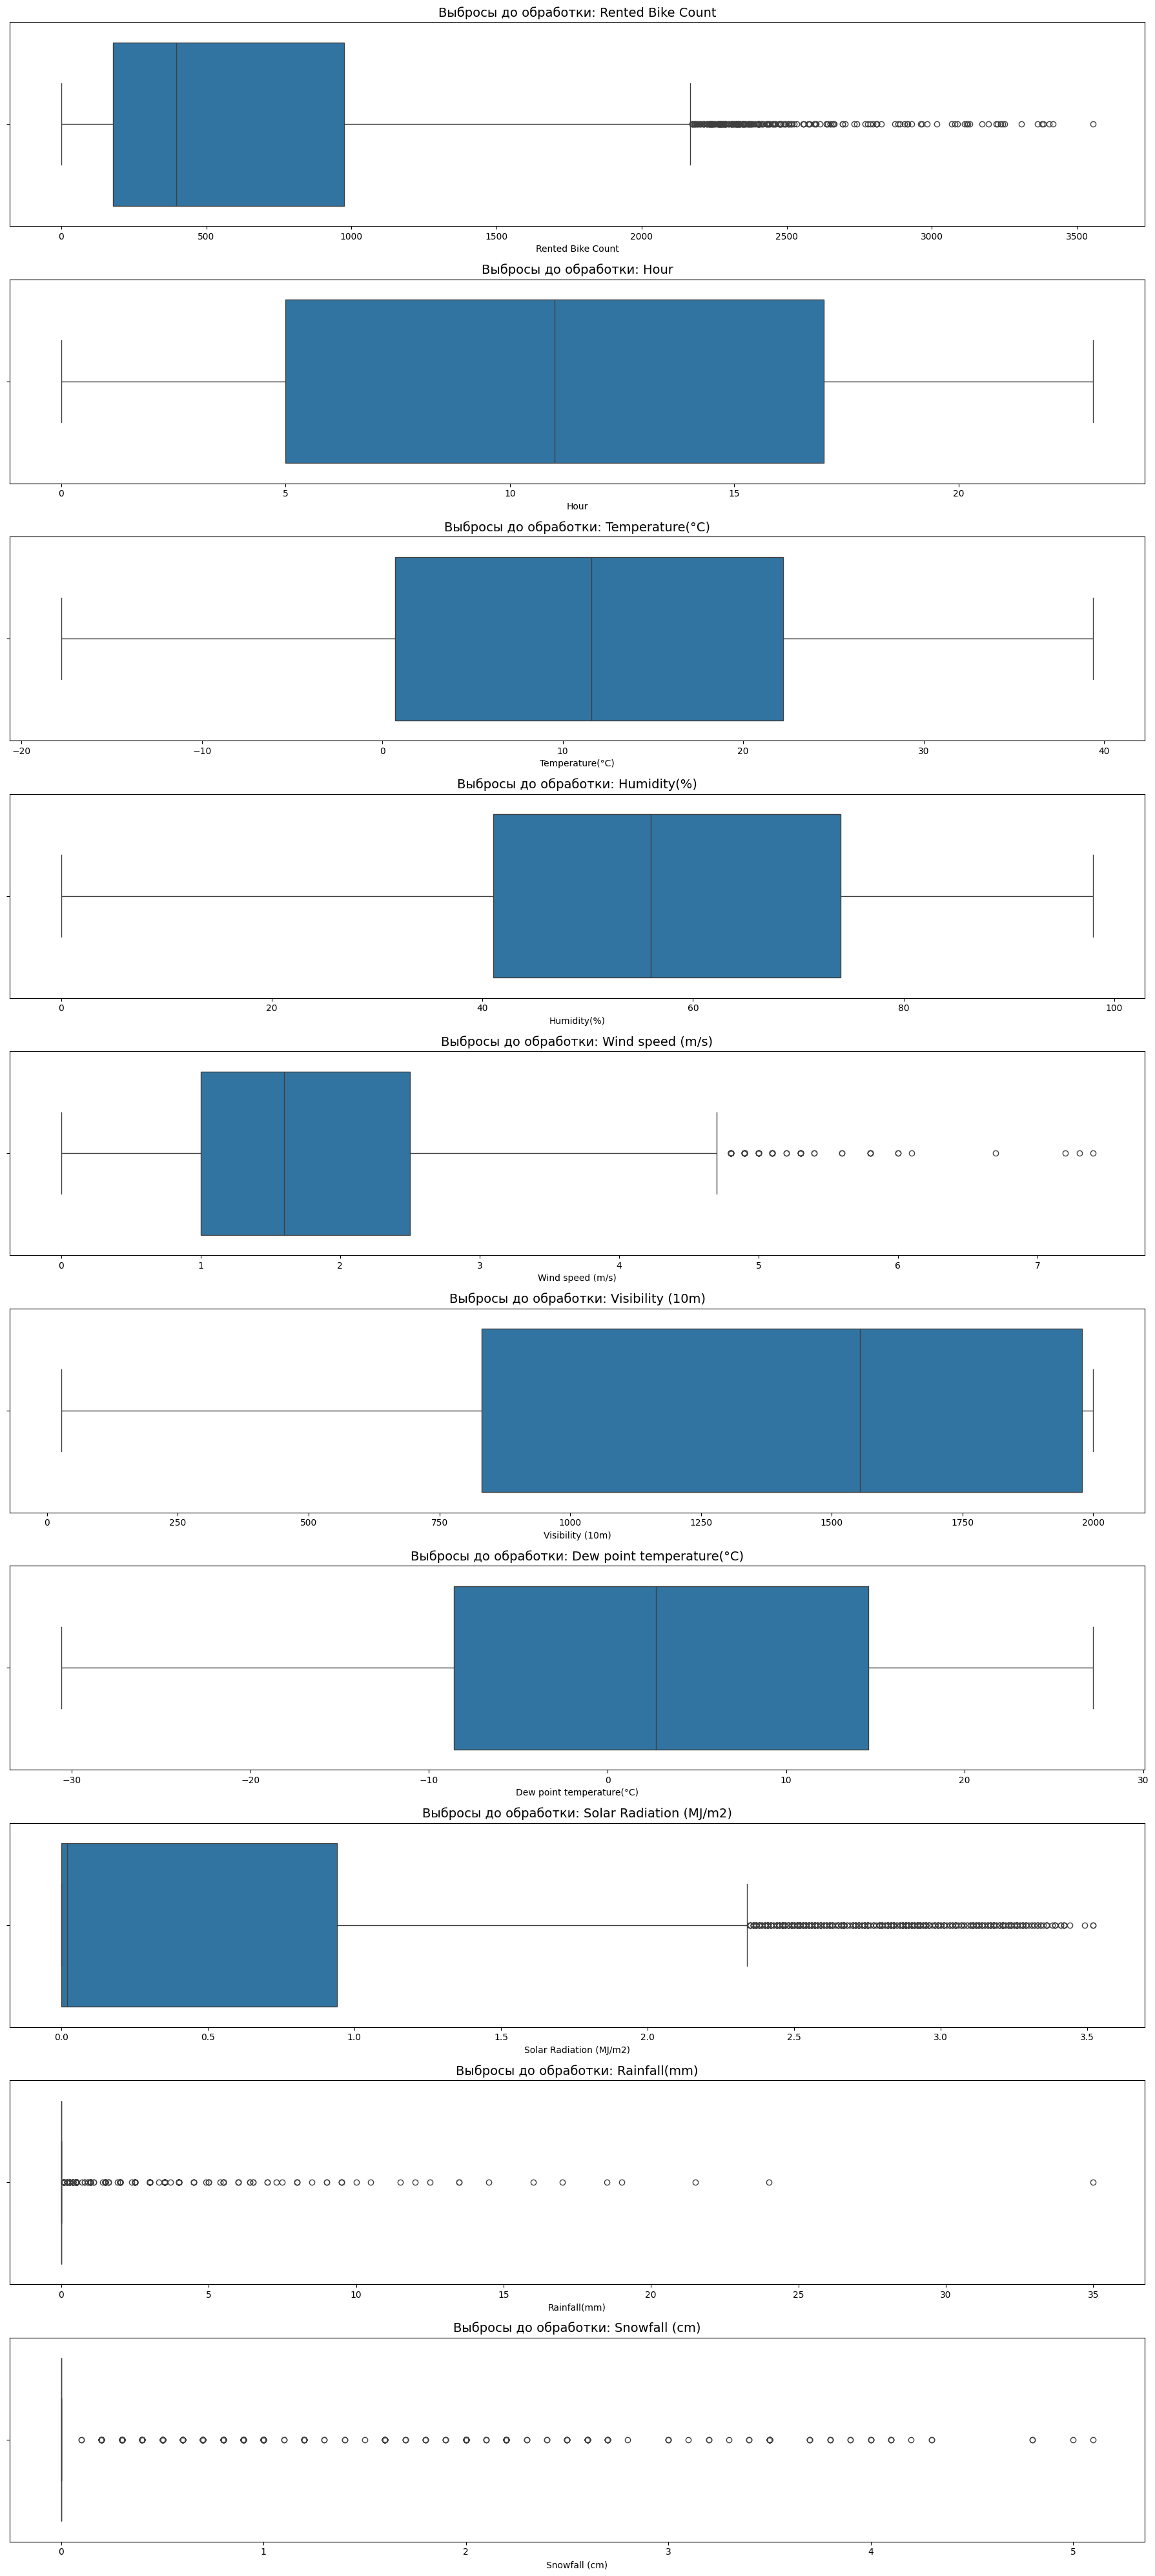

In [117]:
def plot_boxplots(df, cols, title):
    plt.figure(figsize=(18, len(cols) * 4))
    for i, col in enumerate(cols):
        plt.subplot(len(cols), 1, i + 1)
        sns.boxplot(x=df[col])
        plt.title(f"{title}: {col}", fontsize=14)
    plt.tight_layout()
    plt.show()

numeric_columns = train_df.select_dtypes(include=['number']).columns

plot_boxplots(train_df, numeric_columns, "Выбросы до обработки")

## 5. Обработка выбросов в обучающей выборке (замена на граничные значения)

/tmp/ipython-input-820098724.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-8.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df.loc[train_df[col] < lower, col] = lower
/tmp/ipython-input-820098724.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-891.625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df.loc[train_df[col] < lower, col] = lower


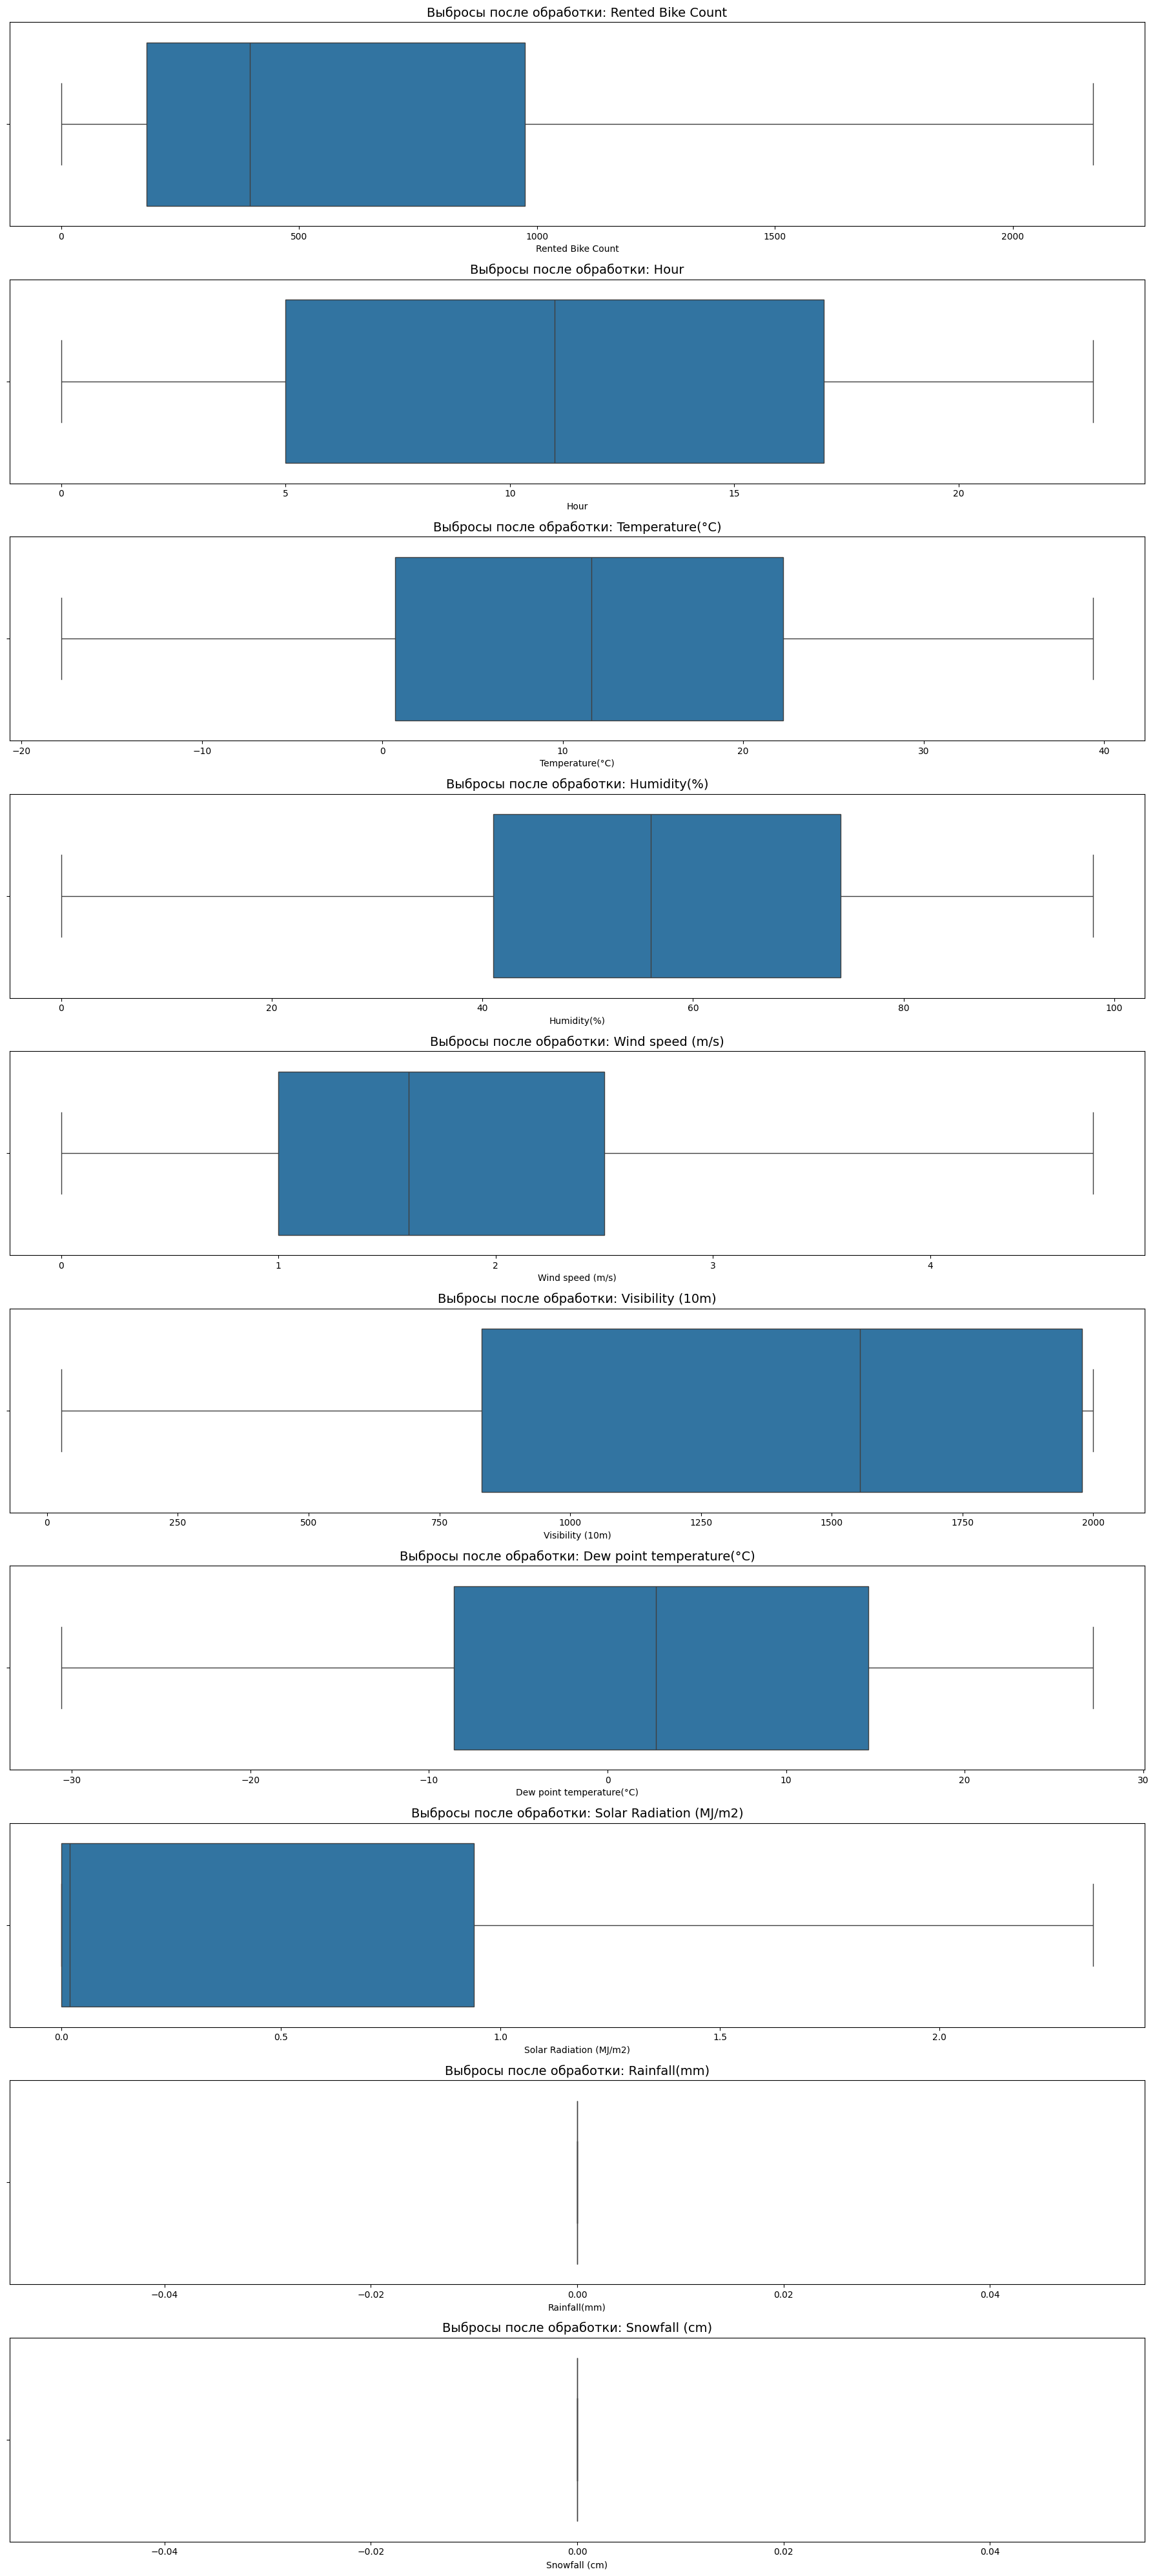

In [118]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

outlier_limits = {}

for col in numeric_columns:
    lower, upper = remove_outliers(train_df, col)
    outlier_limits[col] = (lower, upper)

    train_df.loc[train_df[col] < lower, col] = lower
    train_df.loc[train_df[col] > upper, col] = upper

plot_boxplots(train_df, numeric_columns, "Выбросы после обработки")

## 6. Создание новых признаков: день недели, месяц, время суток (утро: 6-11, день: 12-17, вечер: 18-23, ночь: 0-5)

In [142]:
def get_time_of_day(hour):
    if 6 <= hour <= 11:
        return "Morning"
    elif 12 <= hour <= 17:
        return "Afternoon"
    elif 18 <= hour <= 23:
        return "Evening"
    else:
        return "Night"

train_df = train_df.copy()
test_df = test_df.copy()

train_df['DayOfWeek'] = train_df['Date'].dt.dayofweek
train_df['Month'] = train_df['Date'].dt.month
train_df['TimeOfDay'] = train_df['Hour'].apply(get_time_of_day)

test_df['DayOfWeek'] = test_df['Date'].dt.dayofweek
test_df['Month'] = test_df['Date'].dt.month
test_df['TimeOfDay'] = test_df['Hour'].apply(get_time_of_day)

print("Колонки train_df:")
display(train_df.columns.tolist())

Колонки train_df:


['Date',
 'Rented Bike Count',
 'Hour',
 'Temperature(°C)',
 'Humidity(%)',
 'Wind speed (m/s)',
 'Visibility (10m)',
 'Dew point temperature(°C)',
 'Solar Radiation (MJ/m2)',
 'Rainfall(mm)',
 'Snowfall (cm)',
 'Seasons',
 'Holiday',
 'Functioning Day',
 'DayOfWeek',
 'Month',
 'TimeOfDay']

## 7. Преобразование категориальных переменных в числовой формат с использованием One-Hot Encoding для времен года и времени суток

In [143]:
train_encoded = pd.get_dummies(train_df, columns=['Seasons', 'TimeOfDay'], drop_first=True)
test_encoded = pd.get_dummies(test_df, columns=['Seasons', 'TimeOfDay'], drop_first=True)

display(train_encoded.columns.tolist())

['Date',
 'Rented Bike Count',
 'Hour',
 'Temperature(°C)',
 'Humidity(%)',
 'Wind speed (m/s)',
 'Visibility (10m)',
 'Dew point temperature(°C)',
 'Solar Radiation (MJ/m2)',
 'Rainfall(mm)',
 'Snowfall (cm)',
 'Holiday',
 'Functioning Day',
 'DayOfWeek',
 'Month',
 'Seasons_Summer',
 'Seasons_Winter']

## 8. Масштабирование числовых признаков на обучающей выборке с использованием StandardScaler

In [144]:
scaler = StandardScaler()
train_df[numeric_columns] = scaler.fit_transform(train_df[numeric_columns])
test_df[numeric_columns] = scaler.transform(test_df[numeric_columns])

print("Первые 5 строк train_df после масштабирования:")
display(train_df[numeric_columns].head())

print("Первые 5 строк test_df после масштабирования:")
display(test_df[numeric_columns].head())

print("Среднее по признакам (train):")
display(train_df[numeric_columns].mean().round(2))

print("Стандартное отклонение по признакам (train):")
display(train_df[numeric_columns].std().round(2))

Первые 5 строк train_df после масштабирования:


,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
0,-0.639653,-1.659631,-1.283328,-0.971856,0.377333,1.017634,-1.415655,-0.684236,0.0,0.0
1,-0.722991,-1.515168,-1.306506,-0.924022,-0.960015,1.017634,-1.415655,-0.684236,0.0,0.0
2,-0.774661,-1.370704,-1.345135,-0.876187,-0.768966,1.017634,-1.422713,-0.684236,0.0,0.0
3,-0.884667,-1.226241,-1.360586,-0.828353,-0.864491,1.017634,-1.415655,-0.684236,0.0,0.0
4,-0.933004,-1.081778,-1.345135,-1.019691,0.472857,1.017634,-1.486237,-0.684236,0.0,0.0


Первые 5 строк test_df после масштабирования:


,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
6132,0.143728,0.073928,1.698833,-0.158669,0.759432,0.449374,1.435831,1.938765,0.0,0.0
6133,0.100392,0.218391,1.667930,-0.158669,-0.100292,0.142642,1.407598,0.859444,0.0,0.0
6134,0.022054,0.362854,1.714285,-0.110834,-0.673441,0.008648,1.471121,0.495487,0.0,0.0
6135,0.118726,0.507318,1.745188,-0.302172,-0.004767,0.223361,1.407598,0.545688,0.0,0.0
6136,0.438745,0.651781,1.706559,-0.254338,0.377333,0.701216,1.393482,0.457836,0.0,0.0


Среднее по признакам (train):


,0
Rented Bike Count,0.0
Hour,-0.0
Temperature(°C),0.0
Humidity(%),0.0
Wind speed (m/s),-0.0
Visibility (10m),0.0
Dew point temperature(°C),0.0
Solar Radiation (MJ/m2),0.0
Rainfall(mm),0.0
Snowfall (cm),0.0


Стандартное отклонение по признакам (train):


,0
Rented Bike Count,1.0
Hour,1.0
Temperature(°C),1.0
Humidity(%),1.0
Wind speed (m/s),1.0
Visibility (10m),1.0
Dew point temperature(°C),1.0
Solar Radiation (MJ/m2),1.0
Rainfall(mm),0.0
Snowfall (cm),0.0


## 9. Построение графиков распределения целевой переменной до и после обработки выбросов

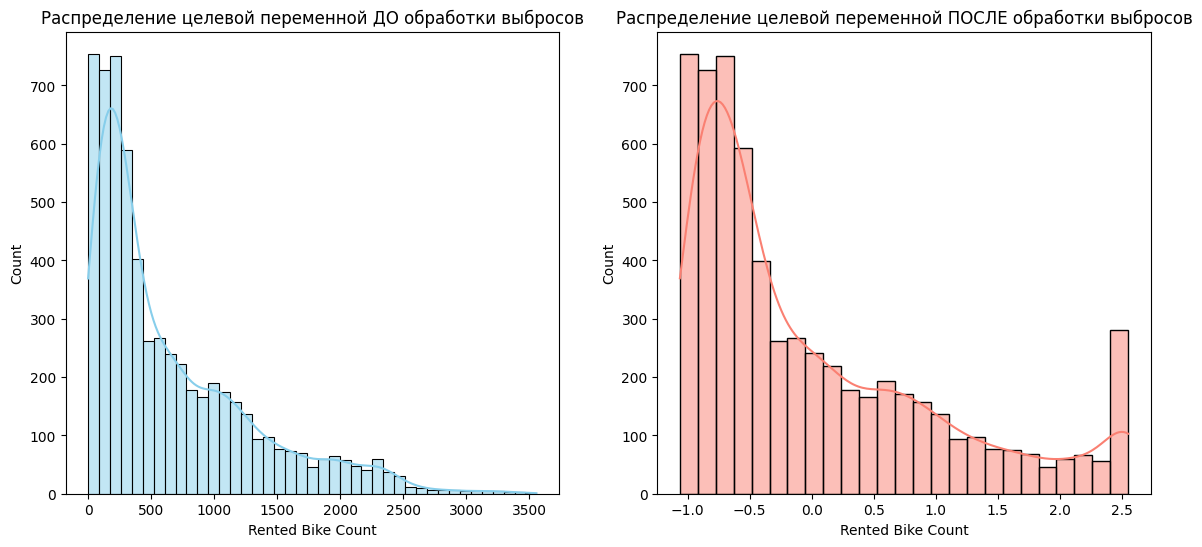

In [122]:
def plot_target_distribution(before_df, after_df, target_col):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(before_df[target_col], kde=True, color="skyblue")
    plt.title("Распределение целевой переменной ДО обработки выбросов")

    plt.subplot(1, 2, 2)
    sns.histplot(after_df[target_col], kde=True, color="salmon")
    plt.title("Распределение целевой переменной ПОСЛЕ обработки выбросов")

    plt.show()

target = "Rented Bike Count"

plot_target_distribution(original_train_df, train_df, target)


## 10. Построение матрицы корреляций между признаками

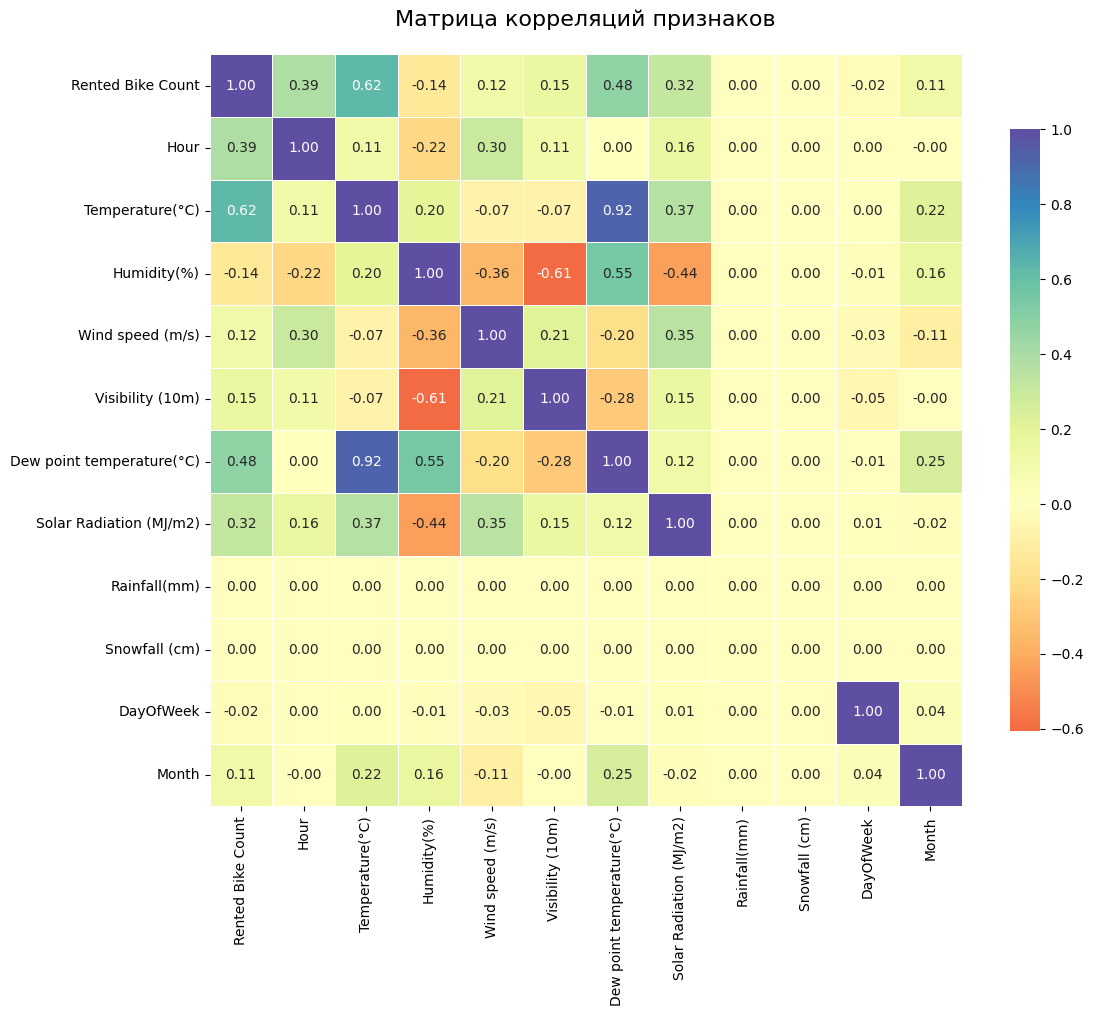

In [123]:
plt.figure(figsize=(12, 10))
corr_matrix = train_df.corr(numeric_only=True).fillna(0)

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Spectral", center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Матрица корреляций признаков", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

## 11. Создание графиков зависимости количества арендованных велосипедов от времени суток и дней недели

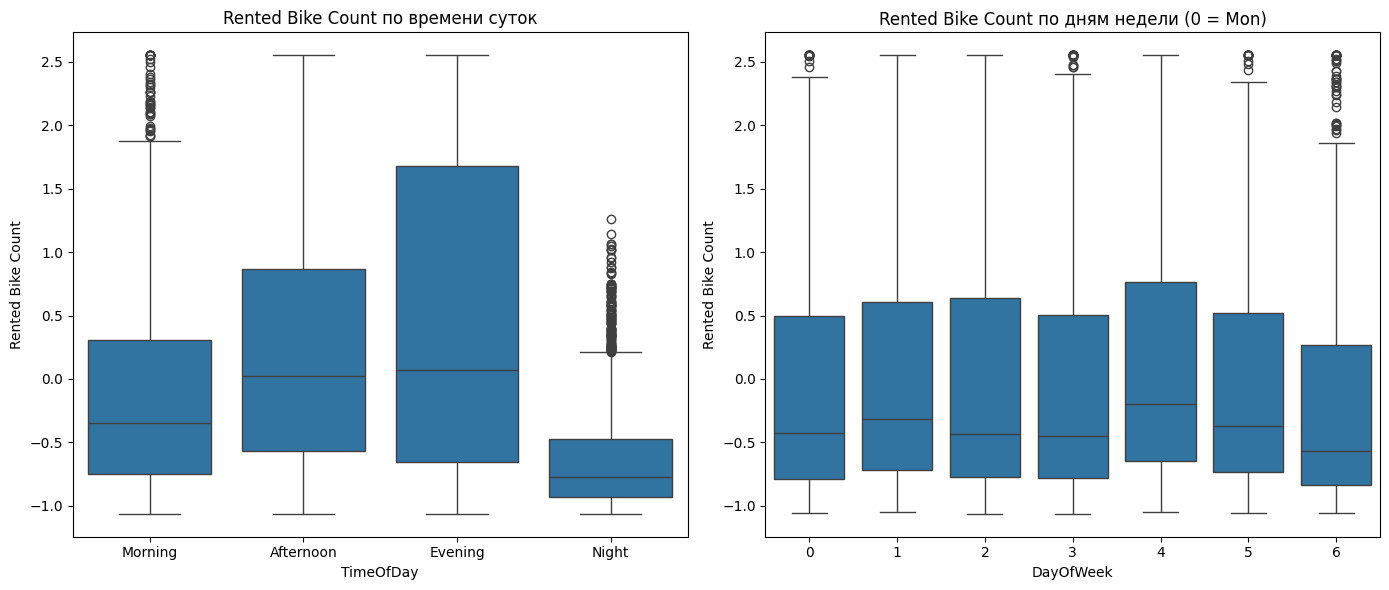

In [124]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
order_tod = ["Morning", "Afternoon", "Evening", "Night"]
sns.boxplot(x="TimeOfDay", y="Rented Bike Count", data=train_df, order=[c for c in order_tod if c in train_df['TimeOfDay'].unique()])
plt.title("Rented Bike Count по времени суток")

plt.subplot(1, 2, 2)
sns.boxplot(x="DayOfWeek", y="Rented Bike Count", data=train_df)
plt.title("Rented Bike Count по дням недели (0 = Mon)")
plt.tight_layout()
plt.show()

## 12. Визуализирование сезонных patterns спроса на велосипеды

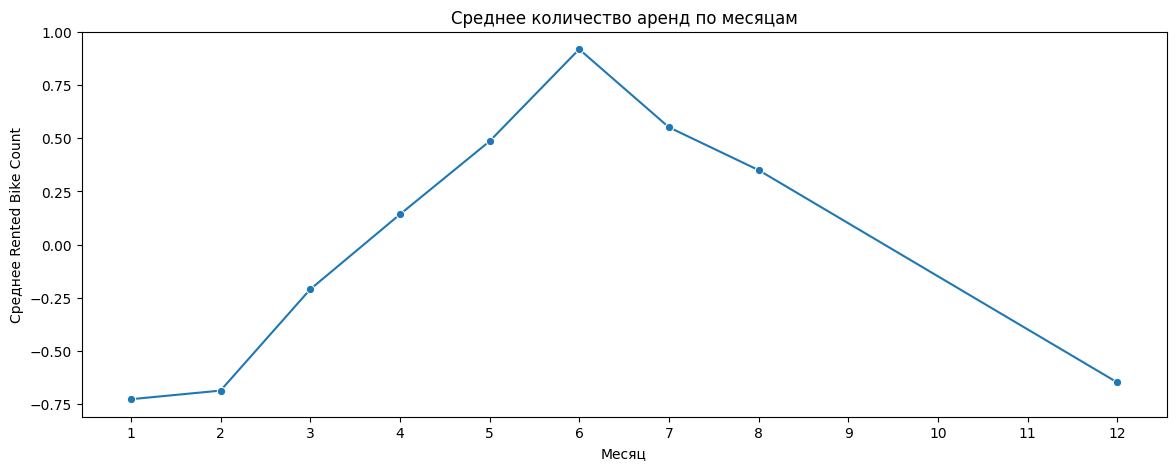

In [125]:
plt.figure(figsize=(14, 5))
month_means = train_df.groupby('Month')['Rented Bike Count'].mean()
sns.lineplot(x=month_means.index, y=month_means.values, marker='o')
plt.title("Среднее количество аренд по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Среднее Rented Bike Count")
plt.xticks(range(1,13))
plt.show()

## 13. Выделение целевой переменной Rented Bike Count

In [150]:
target = "Rented Bike Count"
y_train = train_df[target].copy()
y_test = test_df[target].copy()

print("Первые 5 значений целевой переменной y_train:")
display(y_train.head())

print("Статистика целевой переменной y_train:")
display(y_train.describe().round(2))

print("Первые 5 значений целевой переменной y_test:")
display(y_test.head())

print("Статистика целевой переменной y_test:")
display(y_test.describe().round(2))

Первые 5 значений целевой переменной y_train:


,Rented Bike Count
0,-0.639653
1,-0.722991
2,-0.774661
3,-0.884667
4,-0.933004


Статистика целевой переменной y_train:


,Rented Bike Count
count,6132.00
mean,0.00
std,1.00
min,-1.06
25%,-0.76
50%,-0.40
75%,0.56
max,2.55


Первые 5 значений целевой переменной y_test:


,Rented Bike Count
6132,0.143728
6133,0.100392
6134,0.022054
6135,0.118726
6136,0.438745


Статистика целевой переменной y_test:


,Rented Bike Count
count,2628.00
mean,0.32
std,1.08
min,-1.06
25%,-0.63
50%,0.22
75%,0.95
max,4.43


## 14. Определение наборов признаков для модели, исключив сильно коррелирующие переменные

In [127]:
numeric_df = train_df.select_dtypes(include=[np.number]).copy()
corr_with_target = numeric_df.corr().abs()[target]

threshold = 0.85
to_drop = [col for col in corr_with_target.index if col != target and corr_with_target[col] > threshold]
print("Удаляем сильно коррелирующие (с целевой > {:.2f}):".format(threshold), to_drop)

X_train = numeric_df.drop(columns=[target] + to_drop)
X_test = test_df[X_train.columns].copy()

print("Форма X_train:", X_train.shape, "X_test:", X_test.shape)

Удаляем сильно коррелирующие (с целевой > 0.85): []
Форма X_train: (6132, 11) X_test: (2628, 11)


## 15. Обучение трех моделей регрессии: Linear Regression, Random Forest Regressor и Gradient Boosting Regressor

In [145]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42)
}

fitted_models = {}
train_metrics = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    fitted_models[name] = model
    preds_train = model.predict(X_train)
    train_metrics[name] = {
        "MAE": mean_absolute_error(y_train, preds_train),
        "RMSE": np.sqrt(mean_squared_error(y_train, preds_train)),
        "R2": r2_score(y_train, preds_train)
    }

train_metrics_df = pd.DataFrame(train_metrics).T
print("Метрики на TRAIN:")
display(train_metrics_df)

Метрики на TRAIN:


,MAE,RMSE,R2
Linear Regression,0.512364,0.678209,0.540032
Random Forest,0.061299,0.113200,0.987186
Gradient Boosting,0.188668,0.306254,0.906208


## 16. Оценка производительности моделей на тестовой выборке с использованием метрик MAE, RMSE и R²

In [146]:
test_metrics = {}
for name, model in fitted_models.items():
    preds_test = model.predict(X_test)
    test_metrics[name] = {
        "MAE": mean_absolute_error(y_test, preds_test),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds_test)),
        "R2": r2_score(y_test, preds_test)
    }

test_metrics_df = pd.DataFrame(test_metrics).T
print("Метрики на TEST:")
display(test_metrics_df)

Метрики на TEST:


,MAE,RMSE,R2
Linear Regression,0.693760,0.915232,0.281879
Random Forest,0.512310,0.776098,0.483621
Gradient Boosting,0.530882,0.773668,0.486850


## 17. Проведение сравнительного анализа качества моделей

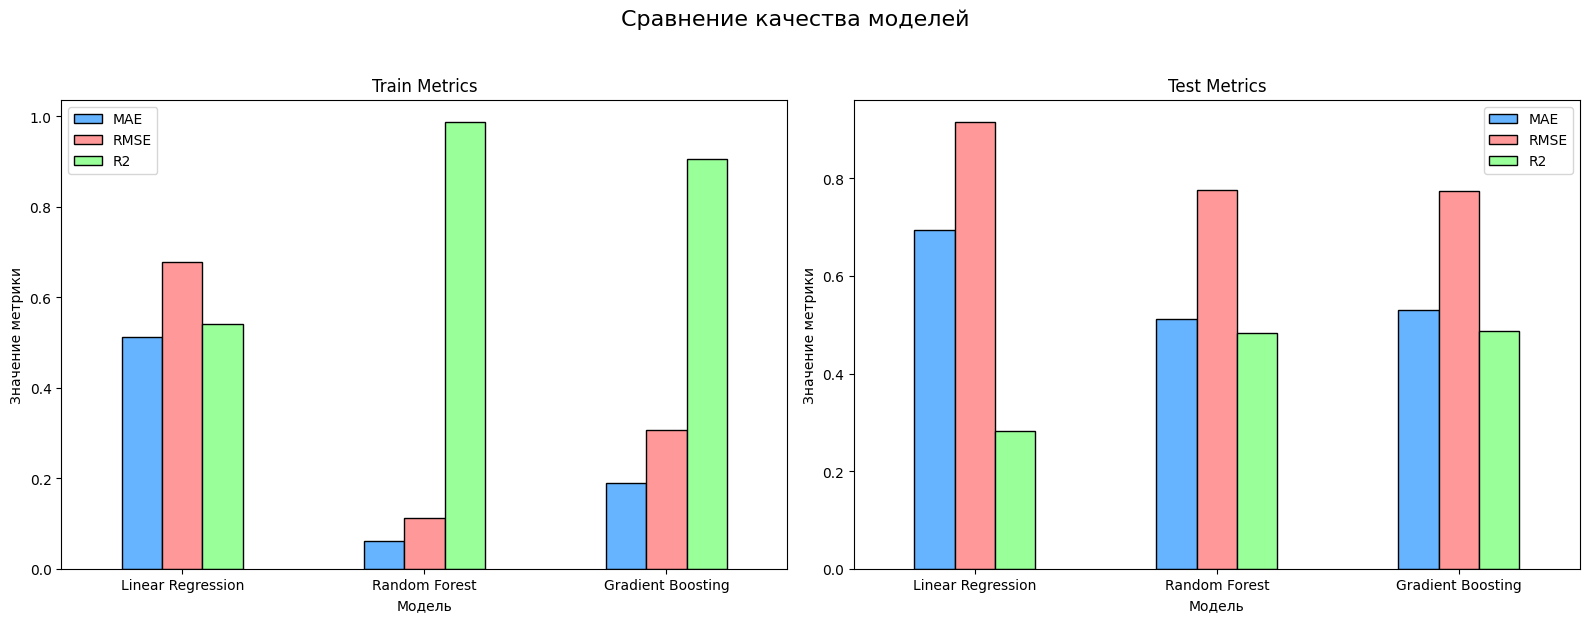

In [130]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, (df, title) in zip(
    axes,
    [(train_metrics_df, "Train Metrics"), (test_metrics_df, "Test Metrics")]
):
    df[['MAE', 'RMSE', 'R2']].plot(
        kind='bar', ax=ax,
        color=['#66b3ff', '#ff9999', '#99ff99'],
        edgecolor='black'
    )
    ax.set_title(title)
    ax.set_ylabel("Значение метрики")
    ax.set_xlabel("Модель")
    ax.tick_params(axis='x', rotation=0)

plt.suptitle("Сравнение качества моделей", fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

## 18. Анализ важности признаков в лучшей модели

Лучшая модель: Gradient Boosting


,MAE_train,RMSE_train,R2_train,MAE_test,RMSE_test,R2_test,score
Linear Regression,0.512,0.678,0.540,0.694,0.915,0.282,0.282
Random Forest,0.061,0.113,0.987,0.512,0.776,0.484,0.484
Gradient Boosting,0.189,0.306,0.906,0.531,0.774,0.487,0.487


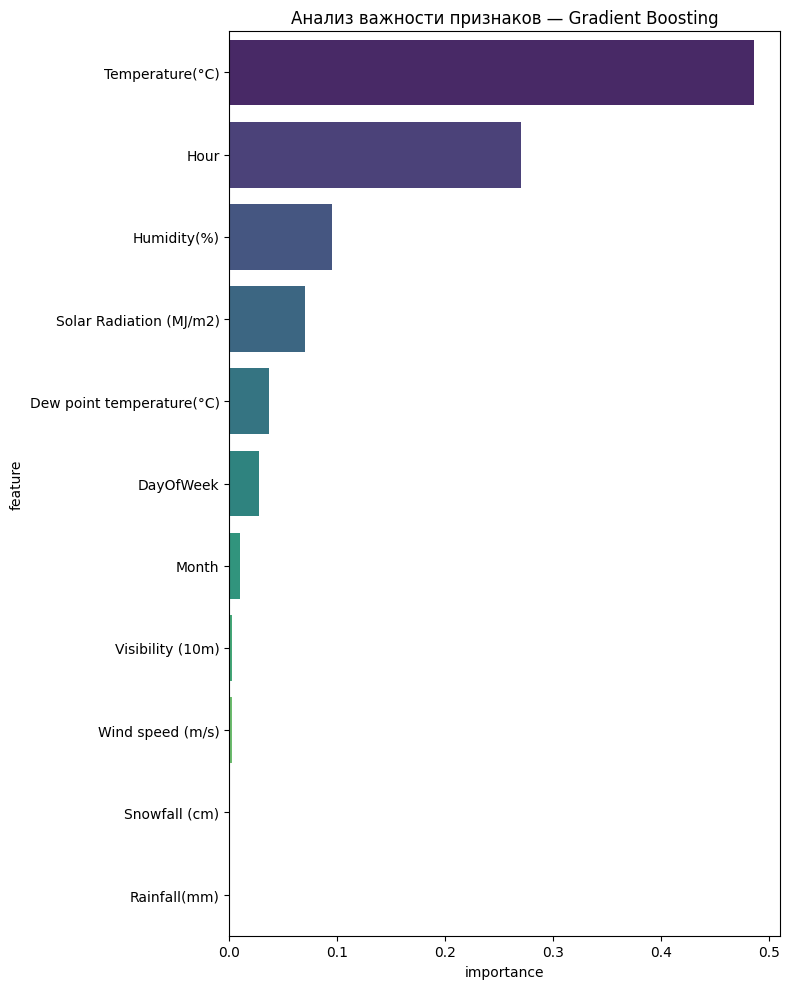

In [131]:
comparison_df = train_metrics_df.add_suffix("_train").join(test_metrics_df.add_suffix("_test"))

comparison_df["score"] = comparison_df["R2_test"]

best_name = comparison_df["score"].idxmax()
best_model = fitted_models[best_name]

print("Лучшая модель:", best_name)
display(comparison_df.round(3))

values = np.abs(getattr(best_model, "feature_importances_", getattr(best_model, "coef_", None)))

feat_imp = (
    pd.DataFrame({"feature": X_train.columns, "importance": values})
    .sort_values("importance", ascending=False)
    .head(25)
)

plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=feat_imp, palette="viridis", hue="feature")
plt.title(f"Анализ важности признаков — {best_name}")
plt.tight_layout()
plt.show()

## 19. Выводы о факторах, наиболее значительно влияющих на спрос на прокат велосипедов

In [148]:
print("\nНаиболее важные факторы, влияющие на спрос:")
if hasattr(best_model, "feature_importances_"):
    top_features = feat_imp.head(5)['feature'].tolist()
else:
    top_features = feat_imp.head(5)['feature'].tolist()
print(" - " + "\n - ".join(top_features))


Наиболее важные факторы, влияющие на спрос:
 - Temperature(°C)
 - Hour
 - Humidity(%)
 - Solar Radiation (MJ/m2)
 - Dew point temperature(°C)
